# Periodiek meten en sturen

In een IoT-toepassing moet je vaak met een zekere regelmaat meten en sturen. Je hoeft niet alles continu te meten, omdat de wereld waaraan je meet (de fysische processen) een zekere traagheid hebben.

Een handig benadering is om voor elke sensor en actuator *periodiek* te werken. Je herhaalt steeds dezelfde cyclus. Bijvoorbeeld:

* voor het aansturen van een lamp in een kas gebruik je een 24-uurs periode. Deze bestaat uit een actieve periode, waarin de lamp *aan* is, en een passieve periode, waarin de lamp uit is.
* voor het aansturen van de watertoevoer gebruik je een periode van 10 minuten. Elke 10 minuten meet je de vochtigheid van de aarde van de plant (moisture); als deze te laag is, geef je gedurende de actieve periode water. In de passieve periode geef je geen water.

Je kunt dit weergeven in de volgende figuur:

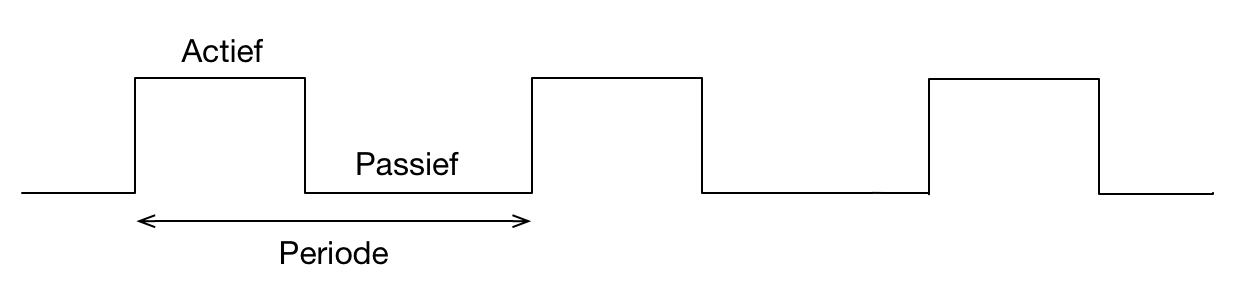

In [1]:
from IPython.display import Image
Image(filename='notebook-figuren/periode-fig.png')

## Een voorbeeld: lamp

Om dit periodieke gedrag te beschrijven in een Python-programma, gebruiken we *timers*: variabelen die het moment aangeven van een bepaalde geplande event. Een timer vergelijken we met de actuele tijd (`now`). Als de timer verstreken is (`now >= timer`) voeren we de actie voor die event uit.

We gebruiken de volgende timers voor het periodieke gedrag van `x`:

* `xStart`: begin van de volgende actieve periode van `x`
* `xStop`: eind van de huidige actieve periode van `x`

We gebruiken de volgende constantes:

* `xPeriod`: periode van `x`
* `xActive`: actief deel van deze periode

Voor de acties aan het begin en aan het eind van de actieve periode gebruiken we:

* `xOn()`
* `xOff()`

We kijgen nu de volgende code:

```Python
xStart = ... initial value: first start
xStop = infinity
xOff()

while True:

    if now >= xStart:
        xOn()
        xStart = xStart + xPeriod
        xStop = now + xActive
    
    if now >= xStop:
        xOff()
        xStop = infinity
        
    sleep(1)
    now += 1

```

Deze acties voor het starten en voor het stoppen zijn onafhankelijk van elkaar, en onafhankelijk van andere acties in de loop. Dit betekent dat we eenvoudig nieuwe sensoren of actuatoren kunnen toevoegen, of bestaande kunnen verwijderen.

De initialisatie hierboven gaat ervan uit dat we in een passieve periode beginnen. Later zullen we een voorbeeld zien waarbij we afhankelijk van de klok actief of niet-actief beginnen.


### Voorbeeld: lamp

We geven hieronder het voorbeeld van de aansturing van een lamp (LED) voor het belichten van een plantje. We volgen de zelfde periode als het daglicht in de zomer: 16,5 uur, van 5:30 uur tot 22:00 uur. De periode `ledPeriod` is 24 uur (`24 * 60 * 60` seconden). De duur van het actieve deel is 16,u uur: `ledActive = (16 * 60 + 30) * 60`. 

Voor het initialiseren van `now` gebruiken we de actuele tijd: in Python krijgen we die met de functie `time.localtime`. Dit is een object met de eigenschappen (velden?) `tm_hour` en `tm_min`. 

In [2]:
import time
tm = time.localtime()
tm.tm_hour, tm.tm_min, tm.tm_sec

(11, 15, 32)

We gebruiken deze waarde om de start van de eerste periode te bepalen (eigenlijk de waarde van `now`):

In [3]:
now = (tm.tm_hour * 60 + tm.tm_min) * 60 + tm.tm_sec
now

40532

In [4]:
infinity = 100 * 400 * 24 * 60 * 60 ## more than 100 year in seconds
infinity

3456000000

In [5]:
def debugLog(log):
    tm = time.localtime()
    tmStr = (str(tm.tm_year) + "-" + str(tm.tm_mon) + "-" + str(tm.tm_mday) + ":" + str(tm.tm_hour) + ":" +
             str(tm.tm_min) + ":" + str(tm.tm_sec))
    print("Log at " + tmStr + " " + log)    

In [6]:
def ledOn():
    # grovepi.digitalWrite(lampPin, 1)
    debugLog("led ON")

def ledOff():
    # grovepi.digitalWrite(lampPin, 0)
    debugLog("led OFF")


In [7]:
ledPeriod = (24 * 60) * 60      ## 24 hours
ledActive = (16 * 60 + 30) * 60 ## 16,5 hours

ledStart = (5 * 60 + 30) * 60     ## 5:30 hour
ledStop = ledStart + ledActive  ## 22:00 hour

if now <= ledStart:
    ledOff()
elif ledStart <= now and now <= ledStop:
    ledOn()
    ledStart = ledStart + ledPeriod
else:
    ledOff()
    ledStart = ledStart + ledPeriod
    ledStop = infinity

while False: ## should be True...
    
    if now >= ledStart:
        ledOn()
        ledStart = ledStart + ledPeriod
        ledStop = now + ledActive
        
    if now >= ledStop:
        ledOff()
        ledStop = infinity
    
    # time.sleep(1)
    now += 1
    debugLog("next")
    

Log at 2015-6-10:11:15:41 led ON


### Voorbeeld: watervoorziening

Voor de watervoorziening hanteren we de volgende regels:

* elke 15 minuten (`periodWater = 15 * 60`) controleren we de vochtigheid van de grond (`moisture`)
* als `moisture < 550` dan geven we gedurende 1 seconde water (`activeWater = 1`)
    * 1 seconde water geven komt ongeveen overeen met 5-6 ml water. Als we elke 15 minuten 6 ml water geven, dan is dit 24 ml per uur, en 24 * 24 = 576 ml per dag, ofwel ruim een halve liter. Dat moet ruim voldoende zijn.

In [8]:
def waterOn():
    moisture = 700 # read Sensor
    if moisture < 550:
        ## grovepi.digitalWrite(waterPin, 1)
        debugLog("water ON")
        return
    else:
        debugLog("no water needed")
        return

def waterOff():
    ## grovepi.digitalWrite(waterPin, 0)
    debugLog("water OFF")

In [9]:
waterPeriod = 15 * 60 ## 15 minutes
waterActive = 1       ## 1 second

waterStart = now + 5 * 60  ## first check after 5 minutes
waterStop = infinity

while now < 5000 : ## should be True...
    
    if now >= waterStart:
        waterOn()
        waterStart = waterStart + waterPeriod
        waterStop = now + waterActive
        
    if now >= stopWater:
        wtaerOff()
        waterStop = infinity
    
    ## time.sleep(1)
    now += 1

## Opmerkingen

* in de uiteindelijke code combineren we deze twee loops, voor de lamp en voor het water; de conditionele acties zijn helemaal onafhankelijk van elkaar, en van andere acties die we in de loop uitvoeren.
* je weet steeds wat de eerstvolgende event is: je kunt een `sleep` doen tot dat moment. In een IoT node die zuinig met energie moet omspringen, kan dat veel schelen. (In dit geval is de energie voor de lamp veel groter dan die voor de Raspberry Pi.)
* we moeten met een bepaalde periode de sensoren uitlezen, om deze door de sturen naar de MQTT broker. Hiervoor kunnen we hetzelfde stramien volgen.
* in de functies waarin we de lamp of de klep aan of uitzetten, kunnen we ook deze informatie naar de MQTT broker sturen. (Eventueel gebruiken we daarvoor een ander onderwerp, en/of een andere broker.)

In [10]:
12 * 60 * 60

43200

In [11]:
ledStart

106200

In [12]:
ledStop

79200

In [13]:
now

40532

In [14]:
63590 / 60

1059.8333333333333

In [15]:
1060 / 60

17.666666666666668

In [16]:
69948 // 60

1165

In [17]:
(106200 // 60) // 60

29

In [30]:
(106200 // 60) % 60

30